<a href="https://colab.research.google.com/github/MohammadRaziei/Deep-Learning-Course/blob/master/HW03/Q5/HW03_Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from sklearn.utils import shuffle

In [4]:
class Model(nn.Module):
  def __init__(self, size, K):
    super(Model, self).__init__()
    # define the layers
    # Input channels = 3, output channels = 20, filter size = (5,5)
    # padding=0 (valid mode), padding=4 (full mode), padding=2 (same mode)
    self.conv1 = nn.Conv2d(3, 20, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear1 = nn.Linear(50*8*8, size)
    self.linear2 = nn.Linear(size, K)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 50*8*8) ## reshaping
    x = self.dropout(x)
    x = F.relu(self.linear1(x))
    x = self.dropout(x)
    x = self.linear2(x)
    return x
    # Note: no final softmax!
    # just like Tensorflow, it's included in cross-entropy function

In [5]:
class CNN():
  def __init__(self, size):
    self.size = size
    
  def fit(self, Xtrain, Ytrain, Xtest, Ytest, training_epochs=5, batch_sz=500):
    N = Xtrain.shape[0]
    K = len(set(Ytrain))
    
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    Xtest, Ytest = shuffle(Xtest, Ytest)
    
    Xtest = Xtest[-10000:]
    Ytest = Ytest[-10000:]
    
    # convert the data arrays into torch tensors
    Xtrain = torch.from_numpy(Xtrain).float()
    Ytrain = torch.from_numpy(Ytrain).long()
    Xtest = torch.from_numpy(Xtest).float()
    Ytest = torch.from_numpy(Ytest).long()
    
    model = Model(self.size, K)
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters())
    
    def train(model, loss, optimizer, inputs, labels):
      # set the model to training mode
      # because dropout has 2 different modes!
      # we only perform dropout in train mode & not test mode
      model.train()
      
      inputs = Variable(inputs, requires_grad=False)
      labels = Variable(labels, requires_grad=False)
      
      optimizer.zero_grad()
      
      # get output from the model, given the inputs
      logits = model.forward(inputs)
      
      # get loss for the predicted output
      cost = loss.forward(logits, labels)
      
      # get gradients w.r.t to parameters
      cost.backward()
      
      # update parameters
      optimizer.step()
      
      return cost.item()
    
    def test(model, loss, inputs, labels):
      model.eval()
      
      inputs = Variable(inputs, requires_grad=False)
      labels = Variable(labels, requires_grad=False)
      
      logits = model.forward(inputs)
      cost = loss.forward(logits, labels)
      
      return cost.item()
    
    def predict(model, inputs):
      model.eval()
      
      inputs = Variable(inputs, requires_grad=False)
      
      logits = model.forward(inputs)
      return logits.data.numpy().argmax(axis=1)
    
    n_batches = N // batch_sz
    
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_c=train(model, loss, optimizer, Xbatch, Ybatch)
        
        if j % 20 == 0:
          train_costs.append(train_c)

          test_c=test(model, loss, Xtest, Ytest)
          test_costs.append(test_c)
          
          p_train = predict(model, Xbatch)
          p_test = predict(model, Xtest)
          
          acc_train = np.mean(p_train == Ybatch.numpy())
          train_accuracies.append(acc_train)

          acc_test = np.mean(p_test == Ytest.numpy())
          test_accuracies.append(acc_test)
          
          print("Epoch", (epoch+1), "Training Cost", "%.2f" % train_c, "Test cost", "%.2f" % test_c, "Training Acc", "%.2f" % acc_train, "Test Acc", "%.2f" % acc_test)
          
    plt.plot(train_costs, label='Training Cost')
    plt.plot(test_costs, label='Test Cost')
    plt.legend()
    plt.show()
    
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(test_accuracies, label='Test accuracy')
    plt.legend()
    plt.show()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=d0d69efa7e6bf87b01a837563ea5ea1b3b8f44d770143ac1cbc4c26533484940
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [22]:
!pip install wget
import wget, os

file_path = lambda x: '{}_32x32.mat'.format(x) # x : train, test, extra
file_url = lambda x: 'http://ufldl.stanford.edu/housenumbers/{}'.format(file_path(x)) # x : train, test, extra

for category in ['train', 'test']:
  if not os.path.exists(file_path(category)):
    wget.download(file_url(category))
print('ALL files is downloaded')

ALL files is downloaded


In [42]:
train = scipy.io.loadmat(file_path('train'))
test = scipy.io.loadmat(file_path('test'))

Xtrain = train['X']
Ytrain = train['y']
#print(Xtrain.shape)           (32, 32, 3, 73257)
#print(Ytrain.shape)           (73257, 1)
Ytrain = Ytrain.flatten() 

Xtest = test['X']
Ytest = test['y']
#print(Xtest.shape)            (32, 32, 3, 26032)
#print(Ytest.shape)            (26032, 1)
Ytest = Ytest.flatten() 

Xtrain = (Xtrain.transpose(3,2,0,1) / 255).astype(np.float32)
Xtest = (Xtest.transpose(3,2,0,1) / 255).astype(np.float32)


In [43]:
import matplotlib.pyplot as plt
def plot_image(img):
  plt.imshow(img,cmap='gray')
  plt.xticks([])
  plt.yticks([])

def fix_image(img):
  return np.transpose(img, axes=(1,2,0))

def plot_image_fix(img):
  plot_image(fix_image(img))

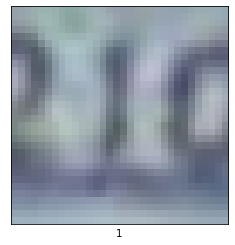

In [44]:
plot_image_fix(Xtest[2])
plt.xlabel(Ytest[2])
plt.show()

In [ ]:

model = CNN(500)
model.fit(Xtrain, Ytrain, Xtest, Ytest)